In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt



In [ ]:

file_path = "carclaims.csv"  
carclaims_df = pd.read_csv(file_path)



In [ ]:

carclaims_df['FraudFound'] = carclaims_df['FraudFound'].map({'No': 0, 'Yes': 1})

def range_to_average(value):
    if isinstance(value, str) and 'to' in value:
        start, end = map(int, value.split(' to '))
        return (start + end) / 2
    elif isinstance(value, str) and value.strip().isdigit():
        return int(value)
    return value

range_columns = ['AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfCars']
for col in range_columns:
    carclaims_df[col] = carclaims_df[col].apply(range_to_average)



In [ ]:

if carclaims_df['PolicyNumber'].dtype == 'object':
    le = LabelEncoder()
    carclaims_df['PolicyNumber'] = le.fit_transform(carclaims_df['PolicyNumber'])

carclaims_df['PolicyNumber'] = pd.to_numeric(carclaims_df['PolicyNumber'], errors='coerce').fillna(0)

categorical_cols = carclaims_df.select_dtypes(include='object').columns
carclaims_encoded = pd.get_dummies(carclaims_df, columns=categorical_cols, drop_first=True)



In [ ]:

X = carclaims_encoded.drop(columns=['FraudFound'])
y = carclaims_encoded['FraudFound']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



In [ ]:

rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_balanced, y_train_balanced)

rf_classifier_best = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")


rf_classifier_best.fit(X_train_balanced, y_train_balanced)

y_pred = rf_classifier_best.predict(X_test)

# Generate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_rep)

# Cross-validation scores
scores = cross_val_score(rf_classifier_best, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean() * 100:.2f}%")




Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 93.90%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.33      0.02      0.03       185

    accuracy                           0.94      3084
   macro avg       0.64      0.51      0.50      3084
weighted avg       0.90      0.94      0.91      3084

Cross-Validation Accuracy: 97.03%


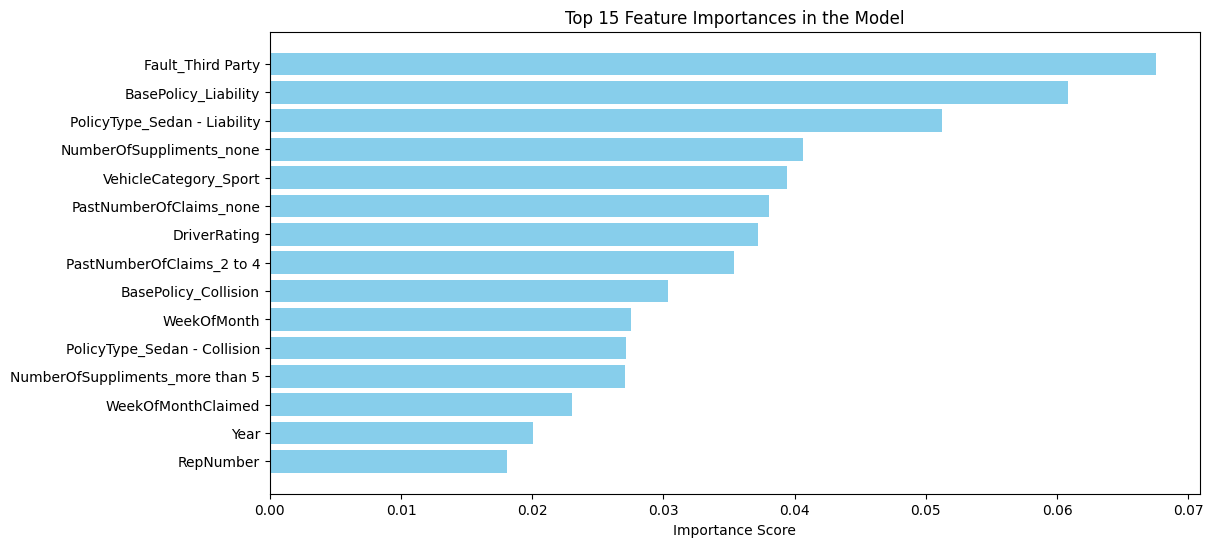


PolicyNumber Importance:
        Feature  Importance
3  PolicyNumber    0.017785


In [7]:
# Analyze feature importance
feature_importances = rf_classifier_best.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Highlight the importance of PolicyNumber
policy_importance = importance_df[importance_df['Feature'] == 'PolicyNumber']

# Plot the top 15 most important features
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances in the Model')
plt.xlabel('Importance Score')
plt.show()

print("\nPolicyNumber Importance:")
print(policy_importance)